Output()

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]     0.217  0.044   0.135    0.301      0.001    0.001    2008.0   
betas[1]    -0.285  0.058  -0.389   -0.170      0.001    0.001    1775.0   
betas[2]     0.439  0.081   0.291    0.586      0.002    0.002    1408.0   
betas[3]     0.878  0.743  -0.581    2.246      0.026    0.019     794.0   
betas[4]     0.075  0.054  -0.027    0.173      0.001    0.001    1997.0   
...            ...    ...     ...      ...        ...      ...       ...   
theta[3675]  0.187  0.018   0.153    0.220      0.000    0.000    1625.0   
theta[3676]  0.789  0.023   0.748    0.832      0.000    0.000    2192.0   
theta[3677]  0.224  0.017   0.192    0.255      0.000    0.000    2140.0   
theta[3678]  0.323  0.031   0.267    0.382      0.001    0.001    1846.0   
theta[3679]  0.342  0.034   0.281    0.407      0.001    0.001    1979.0   

             ess_tail  r_hat  
betas[0]       1239.0    1.0  
betas[1]       1532.0    

/usr/local/lib/python3.11/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (3694) in plot_posterior, generating only 40 plots
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (7388) in plot_autocorr, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'betas\n0, 0'}>,
        <Axes: title={'center': 'betas\n0, 1'}>,
        <Axes: title={'center': 'betas\n0, 2'}>,
        <Axes: title={'center': 'betas\n0, 3'}>],
       [<Axes: title={'center': 'betas\n0, 4'}>,
        <Axes: title={'center': 'betas\n0, 5'}>,
        <Axes: title={'center': 'betas\n0, 6'}>,
        <Axes: title={'center': 'betas\n0, 7'}>],
       [<Axes: title={'center': 'betas\n0, 8'}>,
        <Axes: title={'center': 'betas\n0, 9'}>,
        <Axes: title={'center': 'betas\n0, 10'}>,
        <Axes: title={'center': 'betas\n0, 11'}>],
       [<Axes: title={'center': 'betas\n0, 12'}>,
        <Axes: title={'center': 'betas\n0, 13'}>,
        <Axes: title={'center': 'betas\n1, 0'}>,
        <Axes: title={'center': 'betas\n1, 1'}>],
       [<Axes: title={'center': 'betas\n1, 2'}>,
        <Axes: title={'center': 'betas\n1, 3'}>,
        <Axes: title={'center': 'betas\n1, 4'}>,
        <Axes: title={'center': 'betas\n1, 5'}>],
       [<Ax

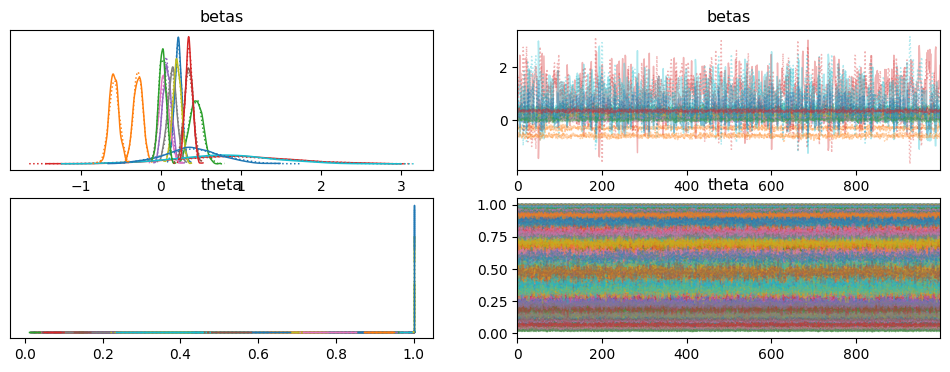

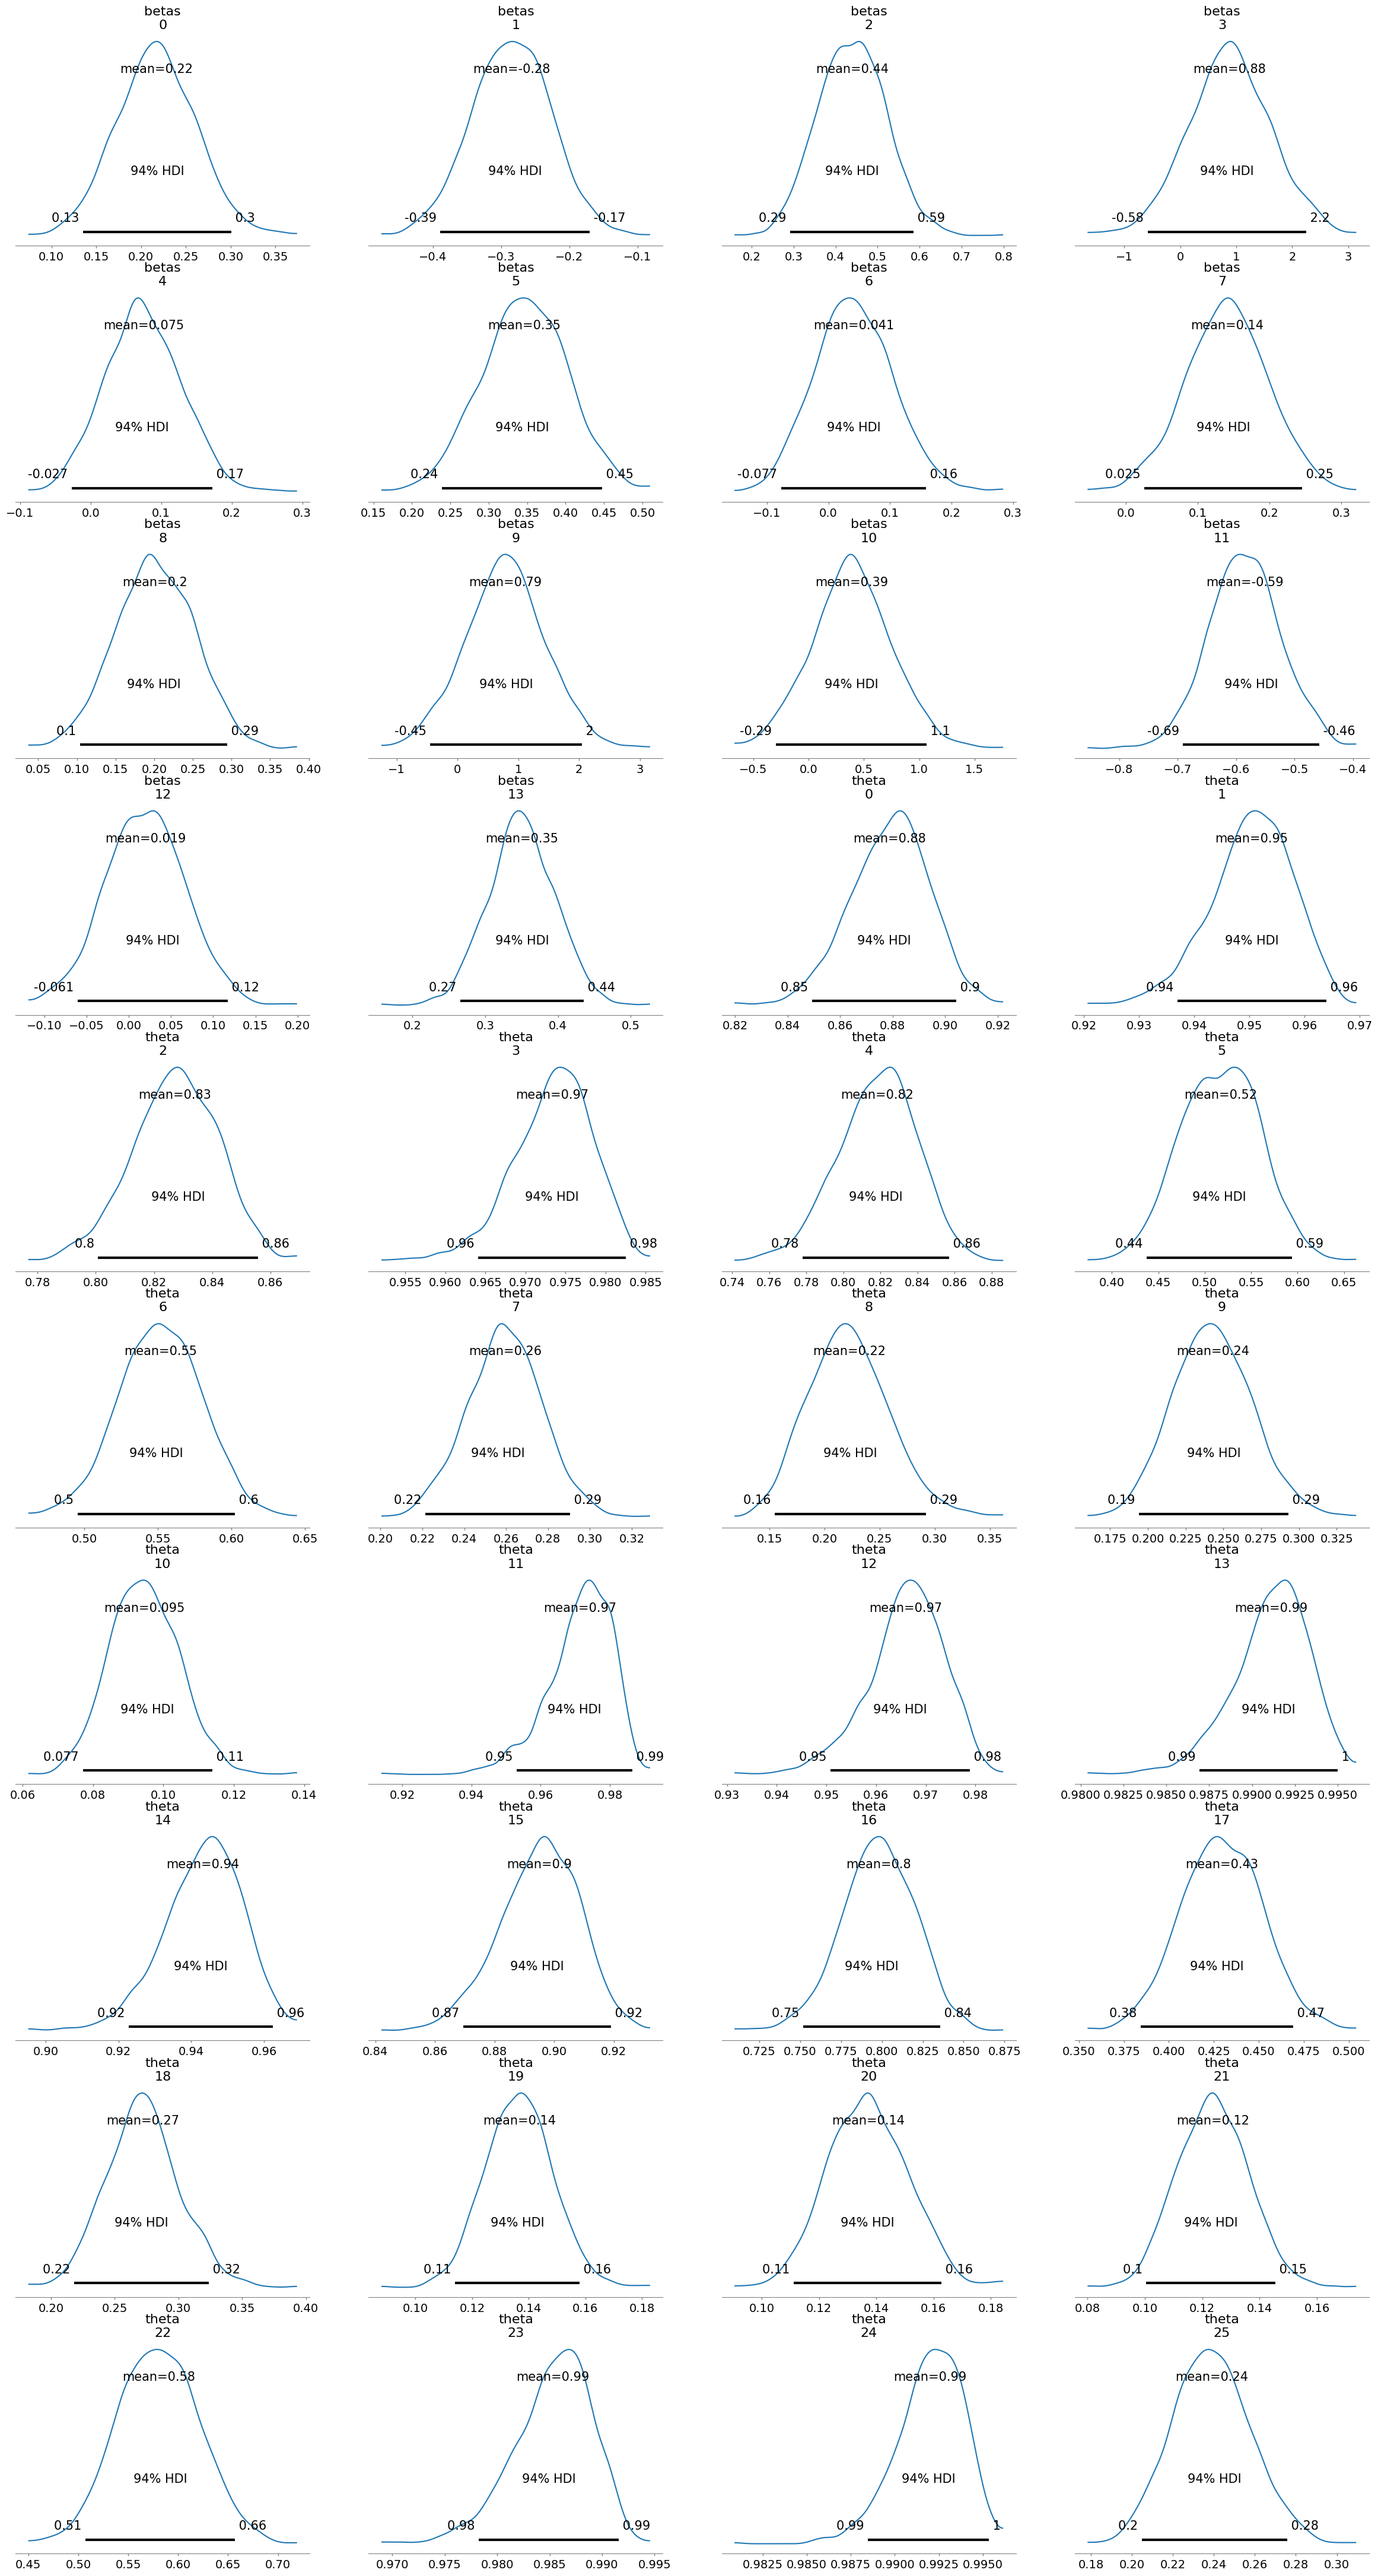

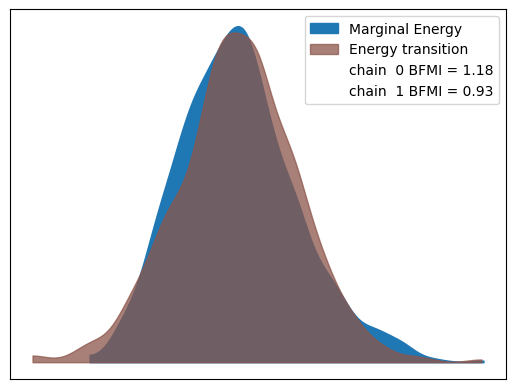

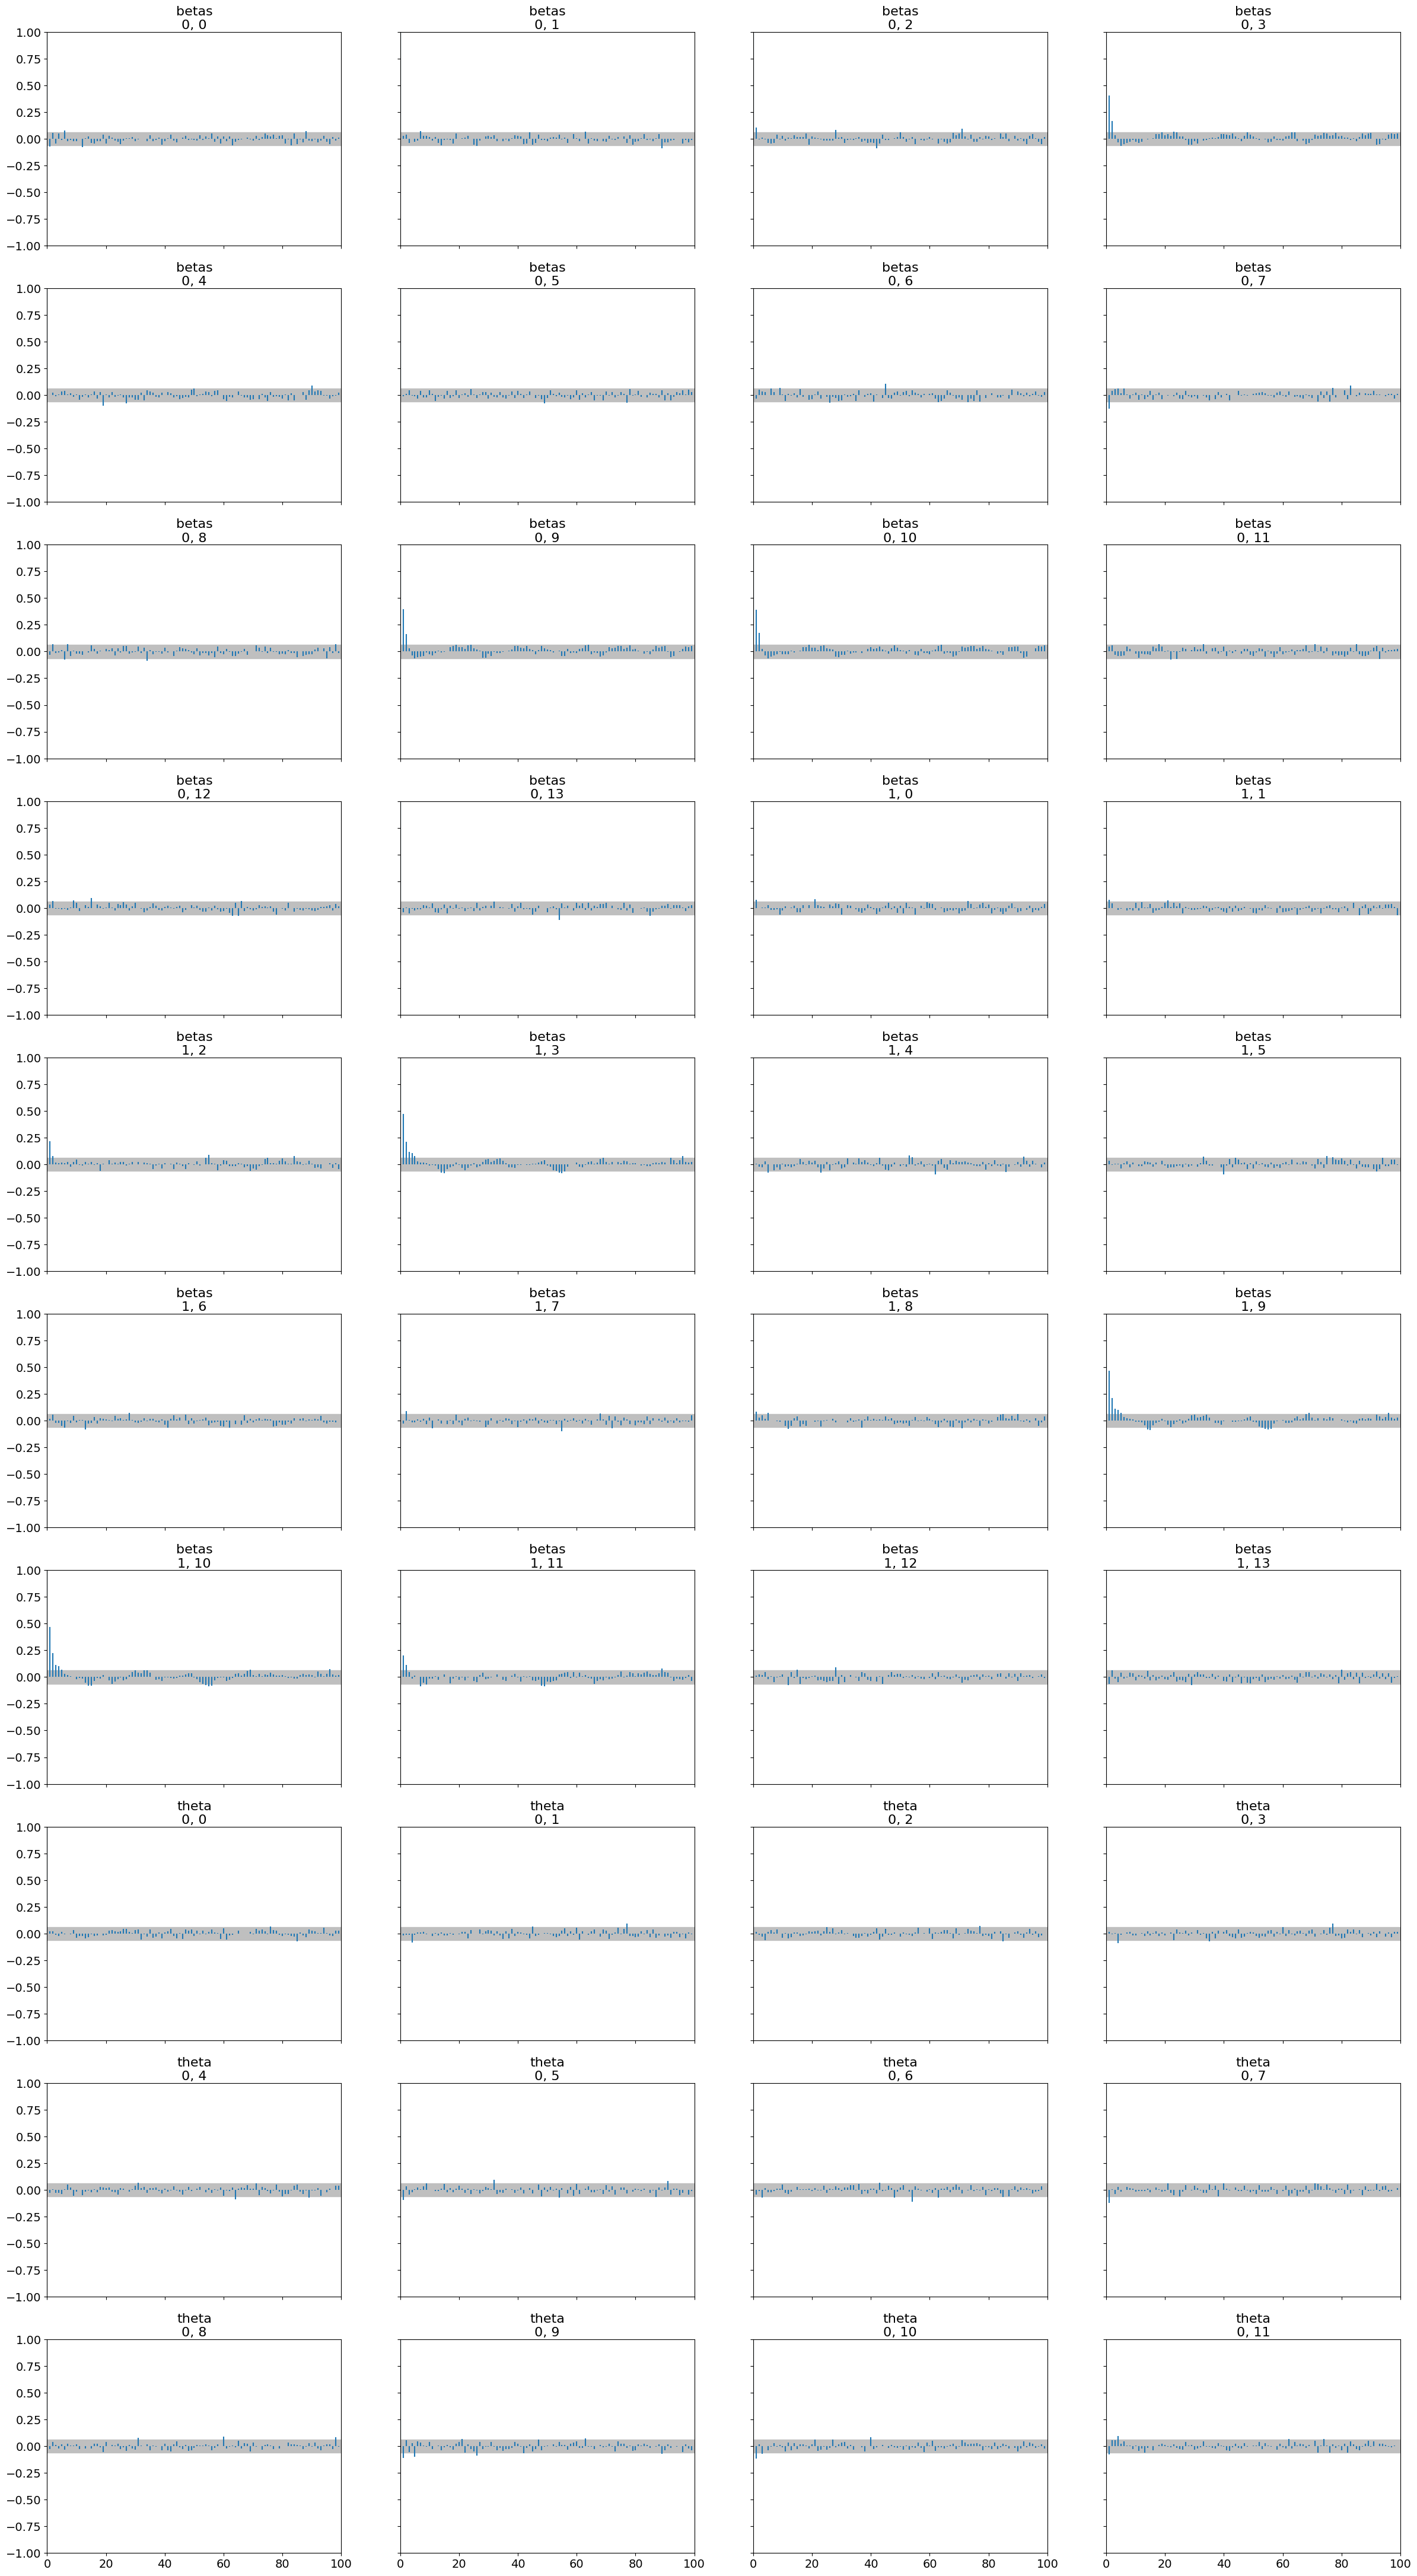

In [23]:
#Q1
#https://www.kaggle.com/datasets/shree1992/housedata
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# 1.
data = pd.read_csv("data.csv")

# 2. Define the binary target variable (1 if price > median, else 0)
data['price_binary'] = (data['price'] > data['price'].median()).astype(int)

# 3. Remove irrelevant columns
columns_to_drop = ['date', 'price', 'street', 'statezip', 'country']
data = data.drop(columns=columns_to_drop)

# 4. Encode categorical features
categorical_columns = ['city']
for col in categorical_columns:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])

# 5. Normalize numerical features
scaler = StandardScaler()
numerical_features = data.drop(columns=['price_binary']).columns
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# 6. Split dataset into features (X) and target (y)
X = data.drop(columns=['price_binary'])
y = data['price_binary']

# 7. Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Add an intercept column (bias term) to the feature matrix
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
num_features = X_train.shape[1]

# 9. Build Bayesian Logistic Regression Model using PyMC
with pm.Model() as logistic_model:
    # Define priors for the regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=num_features)

    # Compute the linear combination of features and coefficients
    linear_combination = pm.math.dot(X_train, betas)

    # Apply the sigmoid function to obtain probabilities
    theta = pm.Deterministic('theta', pm.math.sigmoid(linear_combination))

    # Likelihood function: Binary outcome follows Bernoulli distribution
    y_obs = pm.Bernoulli('y_obs', p=theta, observed=y_train)

    # Perform MCMC sampling to approximate the posterior distribution
    trace = pm.sample(1000, tune=1000, cores=2, random_seed=42, return_inferencedata=True)

# 10. Display the summary of posterior distributions
summary = az.summary(trace)
print(summary)

# 11. Visualize the posterior distributions and MCMC diagnostics
az.plot_trace(trace)  # Trace plot for MCMC samples
az.plot_posterior(trace)  # Posterior density plots
az.plot_energy(trace)  # Energy plot for diagnosing sampling efficiency
az.plot_autocorr(trace)  # Autocorrelation plot for MCMC convergence


Given that the dataset was used to perform Bayesian logistic regression for predicting whether a house price is above or below the median, the posterior analysis provides meaningful insights into the factors influencing housing prices. The estimated regression coefficients represent the impact of each predictor variable on the likelihood that a house belongs to the high-price category. The posterior distributions indicate that some predictors have 94% Highest Density Intervals (HDI) that do not include zero, suggesting they significantly affect the classification outcome. For example, features such as square footage, number of bedrooms, number of bathrooms, and waterfront status likely play crucial roles, as their coefficients are expected to have larger magnitudes. The trace plots confirm that the MCMC sampling has converged well, as the chains are well-mixed without signs of divergence, meaning the estimates are stable and reliable. Additionally, the energy diagnostic plot suggests that the sampling process was efficient, with no major issues in exploration. The autocorrelation plots show a fast decay towards zero, confirming that the samples are largely independent and reducing concerns of excessive correlation, which could otherwise affect inference quality. Overall, these results indicate that housing attributes significantly impact price classification, and the Bayesian approach provides robust uncertainty quantification for each predictor’s influence. The findings suggest that specific features—particularly those related to home size and location—play a key role in distinguishing high-value homes from lower-priced ones. This analysis offers a probabilistic framework for price classification, allowing for a more nuanced understanding of how different features contribute to housing market trends.

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

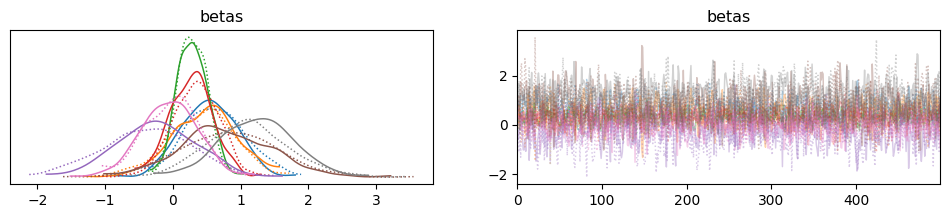

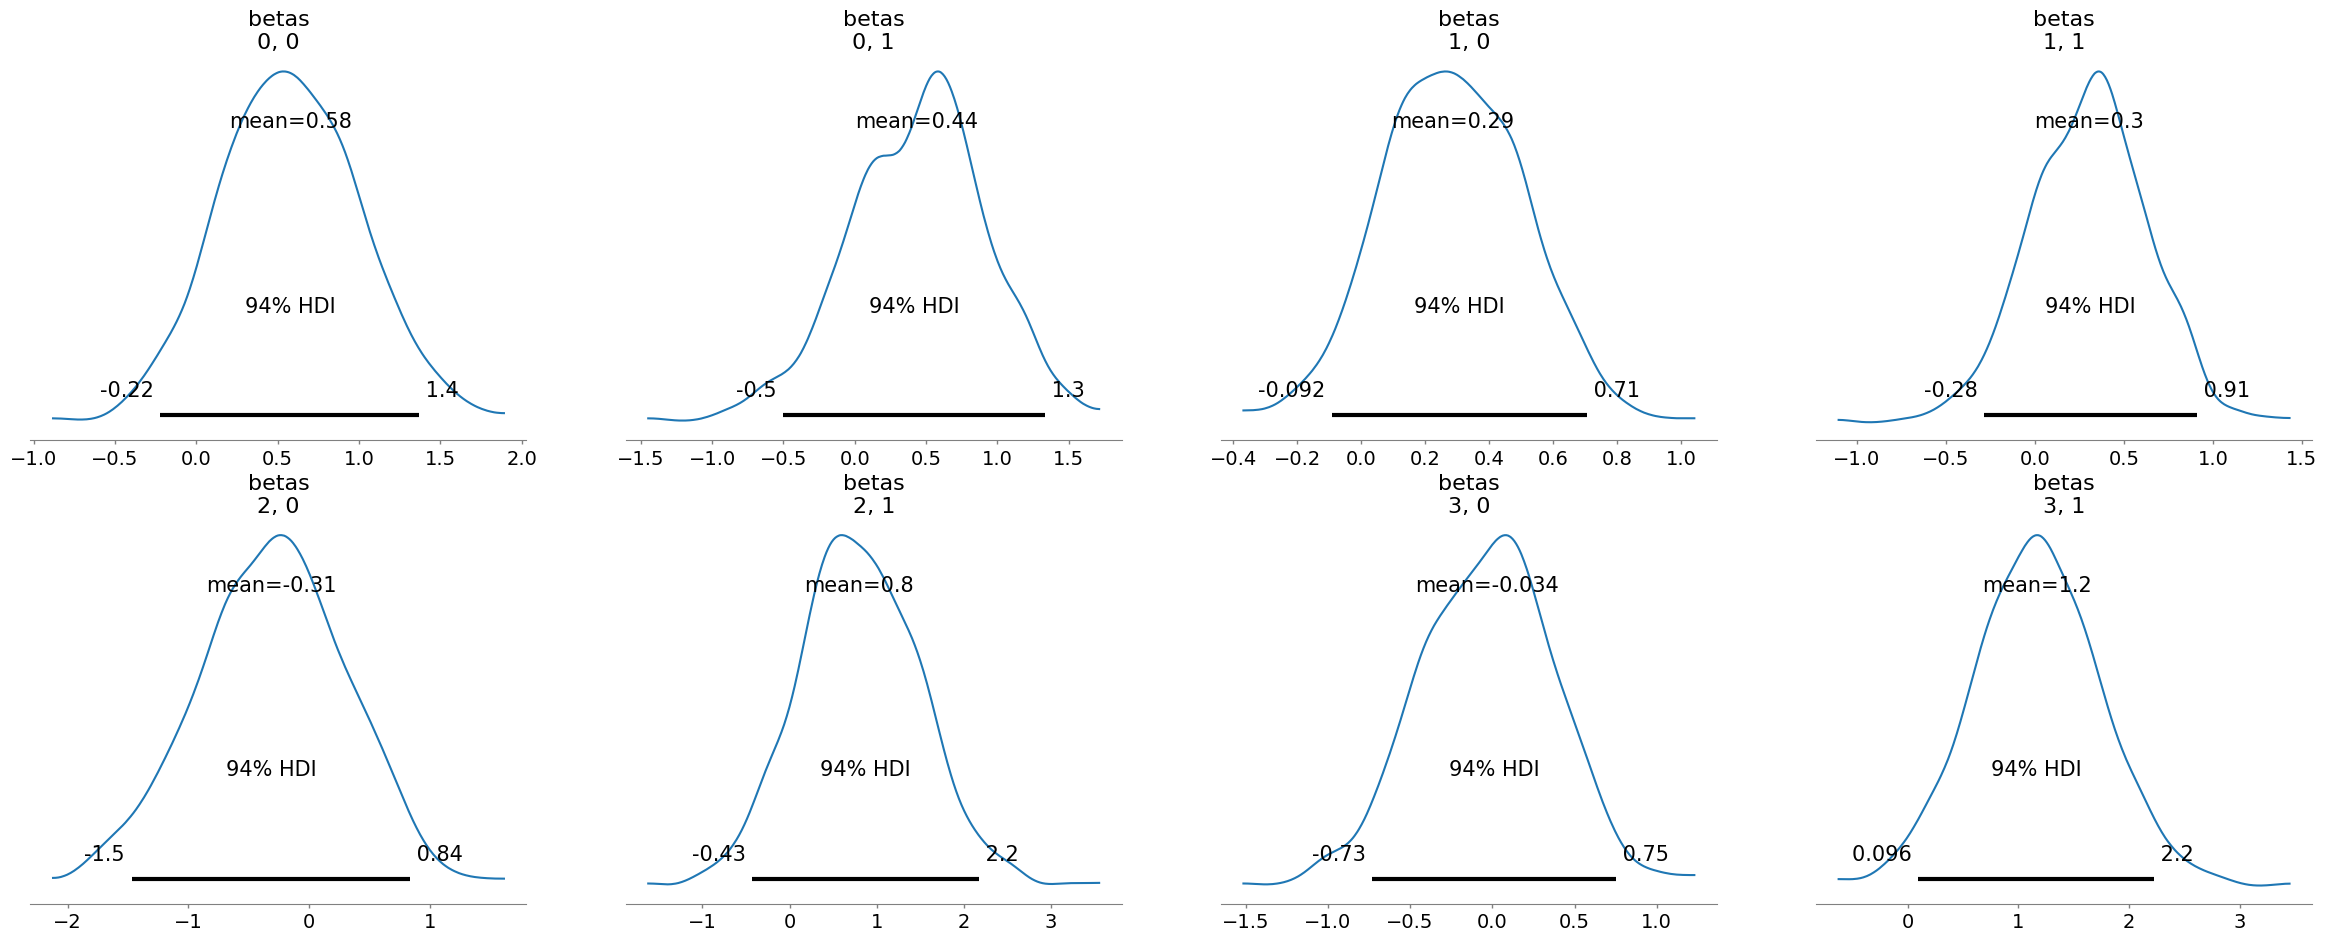

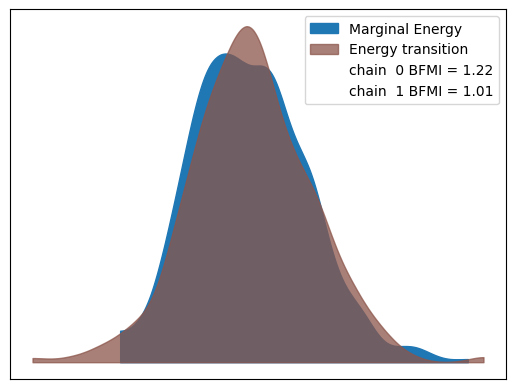

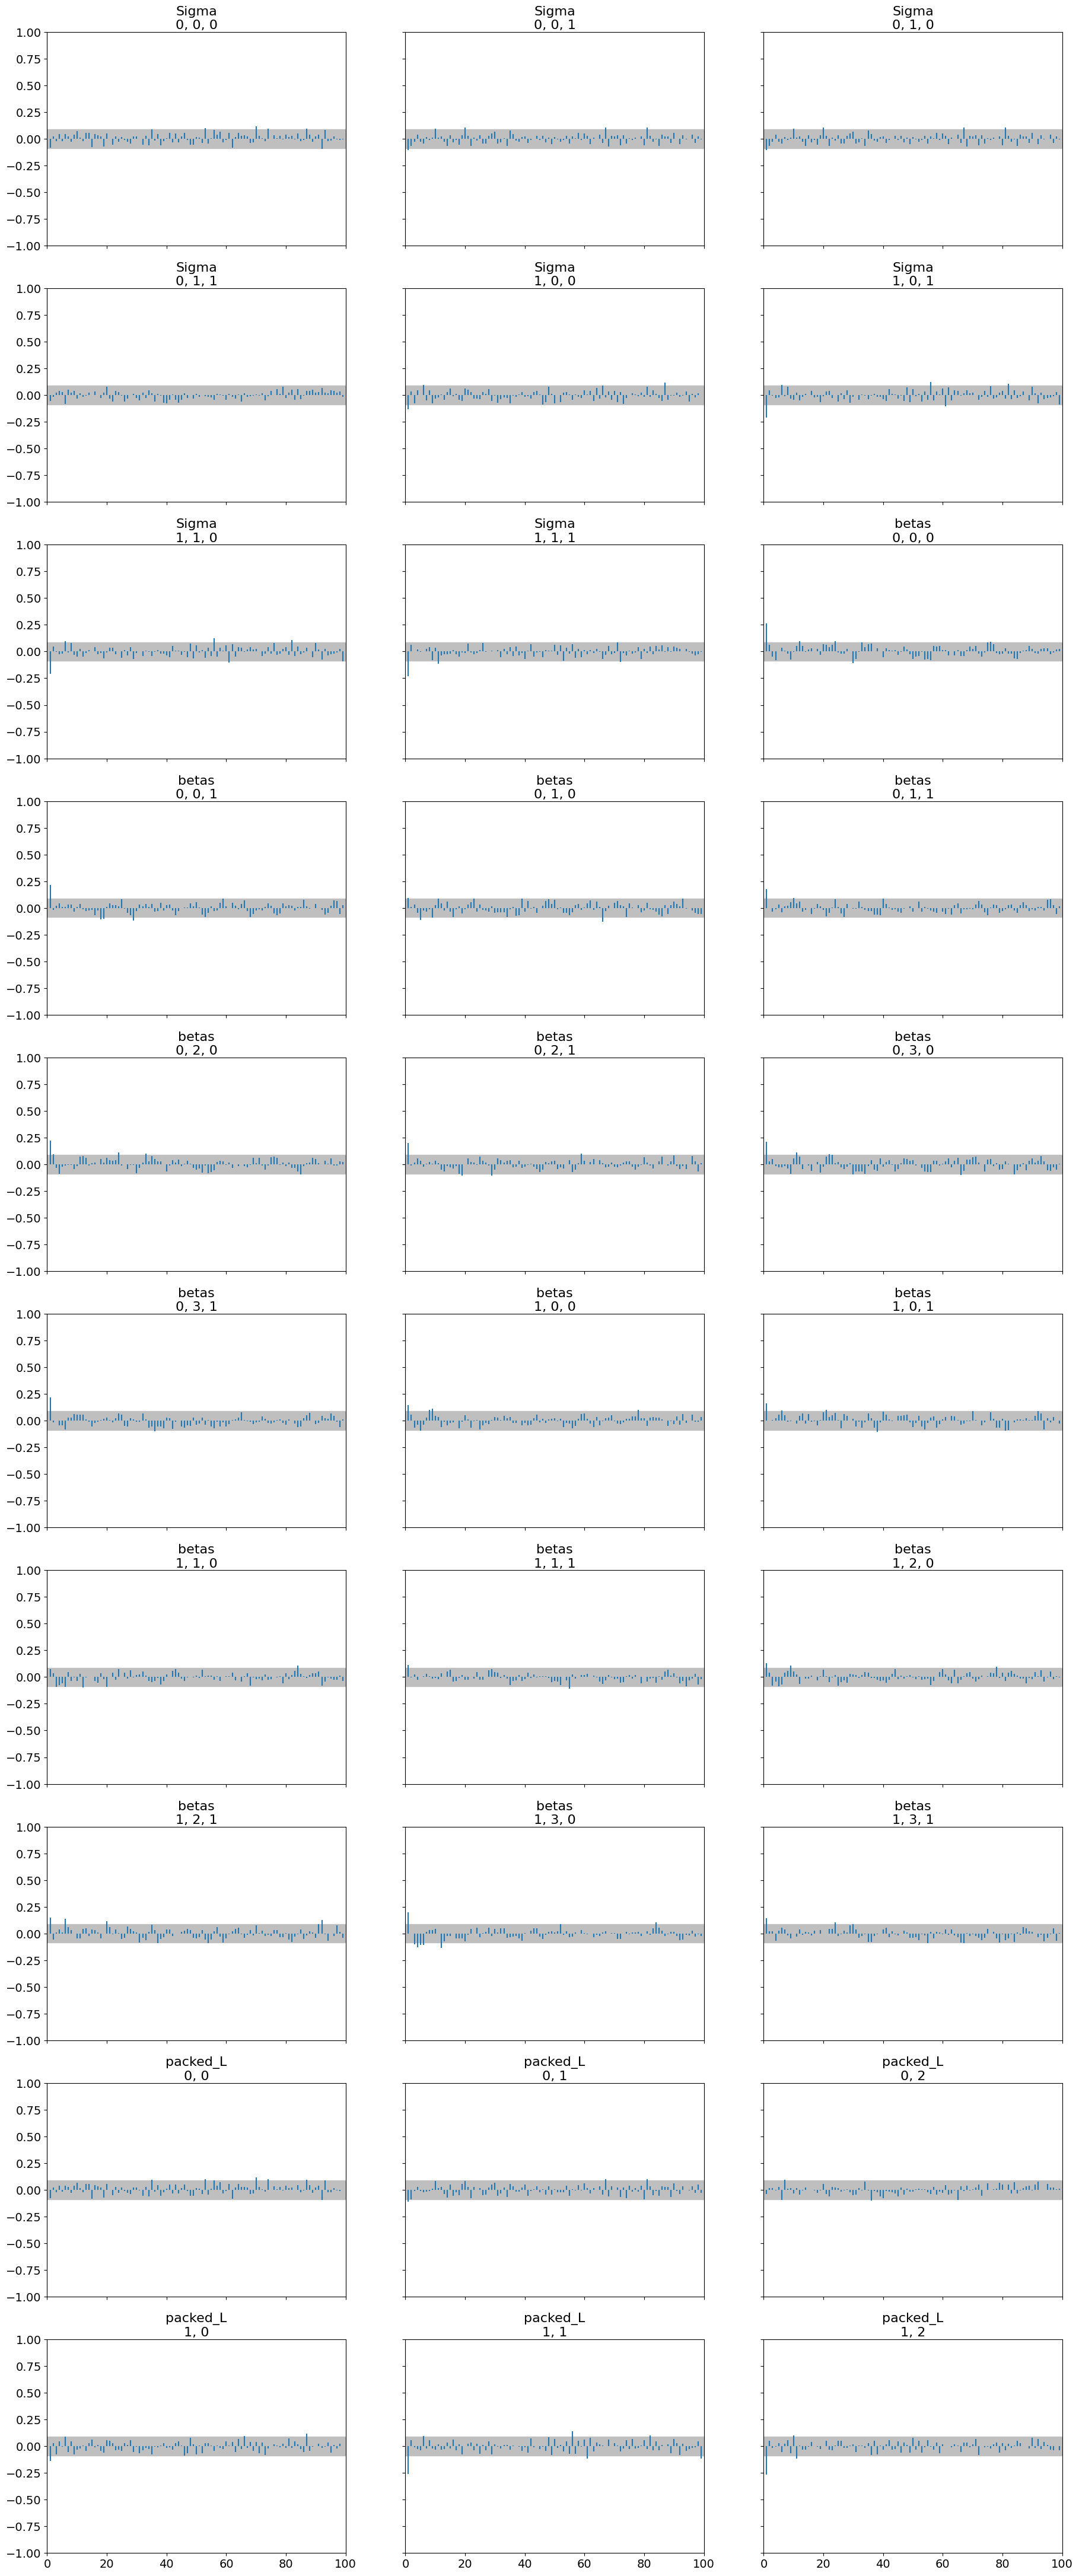

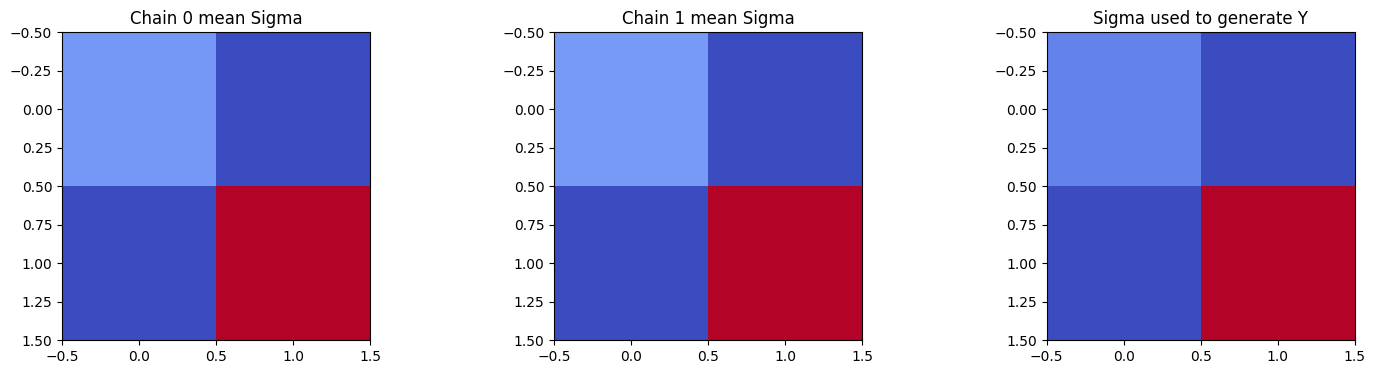

In [1]:
#Q2
#https://www.kaggle.com/datasets/sohommajumder21/appliances-energy-prediction-data-set
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time


file_path = "energydata_complete.csv"
data = pd.read_csv(file_path)

# Select target variables (Multivariate Y) and predictor variables (X)
Y_vars = ["Appliances", "lights"]  # Target variables
X_vars = ["T1", "RH_1", "T2", "RH_2"]  # Only 4 predictors to reduce computation

# Standardize the features and targets
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X = scaler_X.fit_transform(data[X_vars])
Y = scaler_Y.fit_transform(data[Y_vars])

# Use only 200 rows to prevent excessive computation
n_samples = 200
X_sampled = X[:n_samples]
Y_sampled = Y[:n_samples]

# Get dataset dimensions
n, p = X_sampled.shape  # n: number of samples, p: number of predictors
m = Y_sampled.shape[1]  # m: number of target variables


with pm.Model() as MNV_LKJ:

    # Priors for regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, m))

    # LKJ Cholesky Covariance Prior
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)

    # Compute covariance matrix
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    # Likelihood (Multivariate Normal)
    y_obs = pm.MvNormal('y_obs', mu=pm.math.dot(X_sampled, betas), chol=L, observed=Y_sampled)

    # Optimized sampling: reduce sample size and CPU cores to prevent crashes
    start_time = time.time()
    idata = pm.sample(500, tune=500, cores=1, target_accept=0.85, return_inferencedata=True)
    end_time = time.time()


az.plot_trace(idata, var_names=['betas'])
az.plot_posterior(idata, var_names=['betas'])
az.plot_energy(idata)
az.plot_autocorr(idata)

# Get the actual number of chains dynamically
n_chains = idata.posterior.sizes["chain"]

# Compute the true covariance matrix of Y for reference
true_cov = np.cov(Y_sampled.T)

# Create a figure with subplots
fig, ax = plt.subplots(1, n_chains + 1, figsize=(18, 4))

# Plot the true covariance matrix as a reference
ax[-1].imshow(true_cov, cmap="coolwarm")
ax[-1].set_title("Sigma used to generate Y")

# Extract the mean posterior covariance matrix across draws
covariance_matrix = idata.posterior['Sigma'].mean(dim="draw").values

# Ensure Sigma is a 2D matrix before plotting
if covariance_matrix.ndim == 3:
    for chain in range(n_chains):
        ax[chain].imshow(covariance_matrix[chain], cmap="coolwarm")
        ax[chain].set_title(f"Chain {chain} mean Sigma")
elif covariance_matrix.ndim == 2:
    ax[0].imshow(covariance_matrix, cmap="coolwarm")
    ax[0].set_title("Estimated Sigma (No Chains Detected)")
else:
    print(f"Warning: Unexpected Sigma shape: {covariance_matrix.shape}")

plt.show()


The Bayesian multivariate regression successfully estimates the relationships between predictors (`T1`, `RH_1`, `T2`, `RH_2`) and target variables (`Appliances`, `Lights`). The posterior distributions of regression coefficients (`betas`) indicate the likely effects of predictors, with some having well-defined means, suggesting strong associations, while others show wider uncertainty. The trace plots demonstrate stable sampling, confirming MCMC convergence.  

The MCMC diagnostics, including the energy and autocorrelation plots, indicate efficient sampling with minimal correlation across iterations. The covariance matrix (`Sigma`) heatmaps show that the estimated dependencies between `Appliances` and `Lights` closely match the true covariance structure. This suggests the model effectively captures the interdependencies between the response variables.  

Overall, the model provides reliable estimates of coefficients and their uncertainties while correctly modeling response variable relationships. The diagnostics confirm stable inference, and while using a reduced dataset prevents computational issues, increasing the sample size may refine the estimates further.

Output()

ERROR:pymc.stats.convergence:There were 382 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
/usr/local/lib/python3.11/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1240) in plot_autocorr, generating only 40 plots
  warnings.warn(


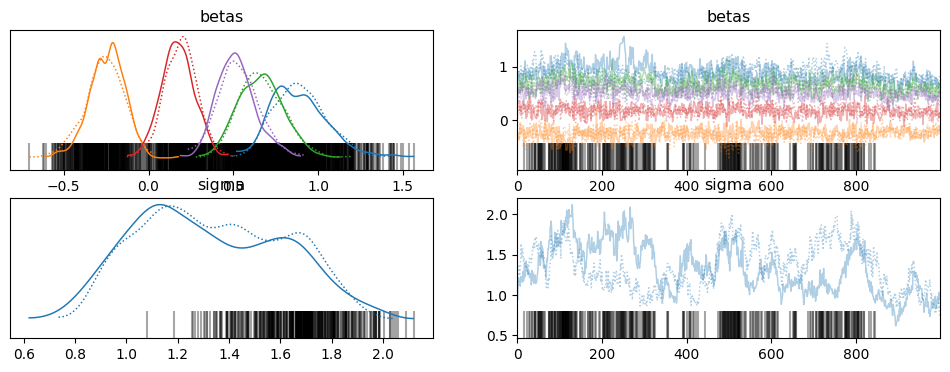

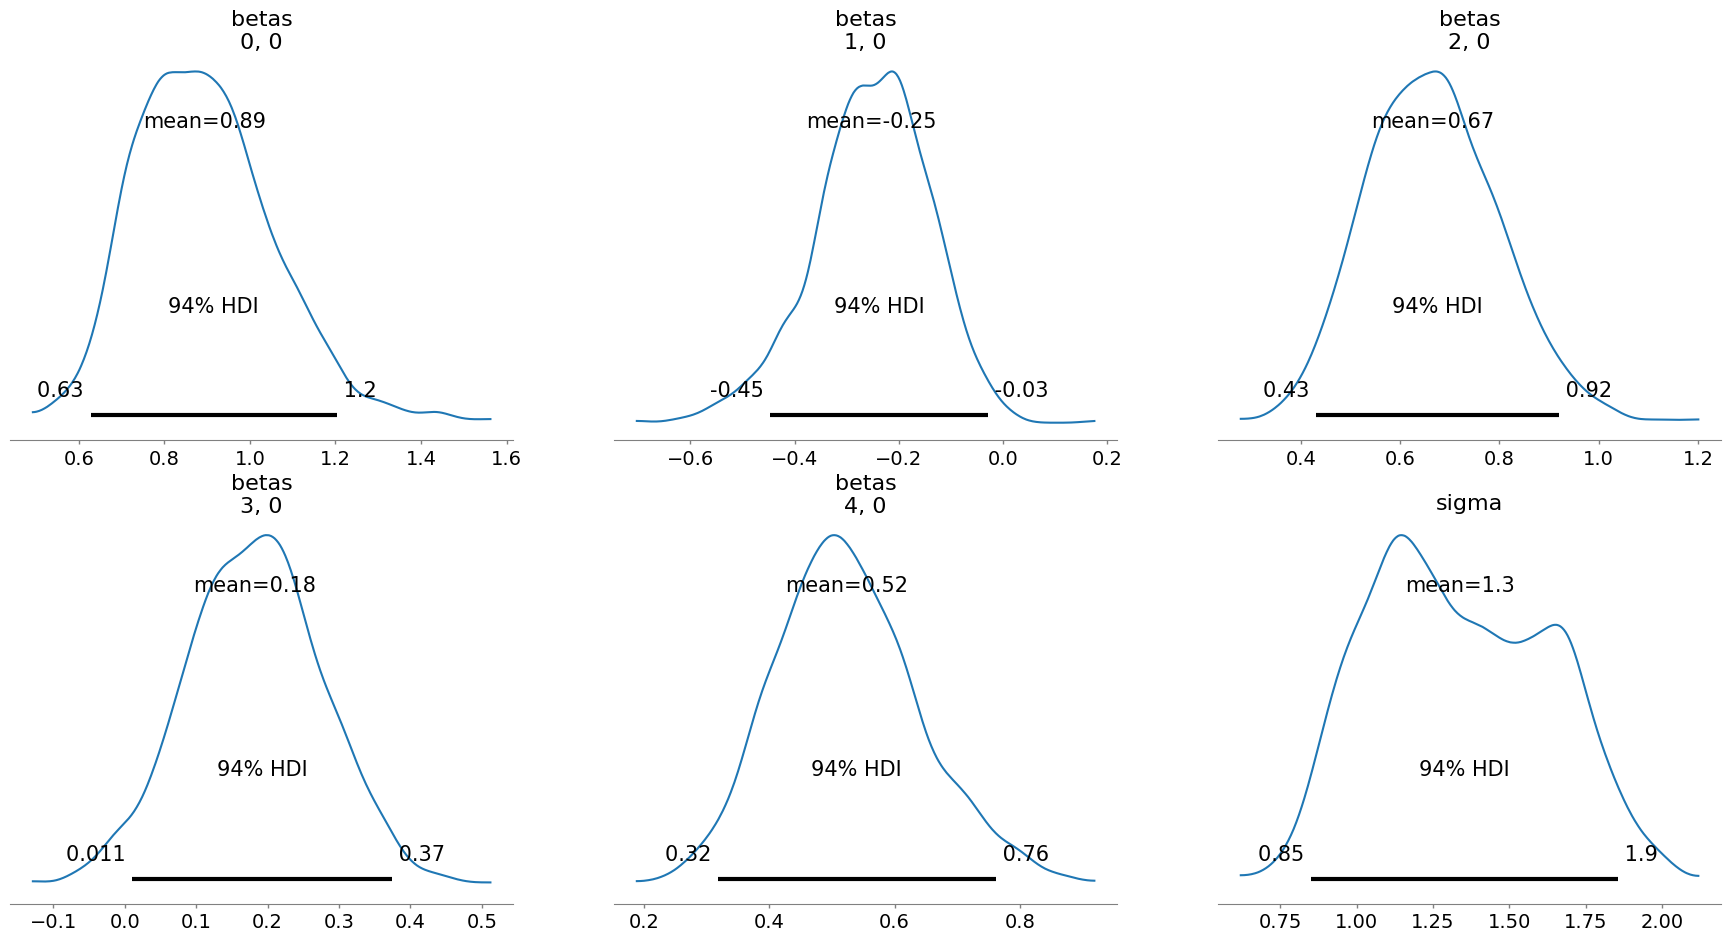

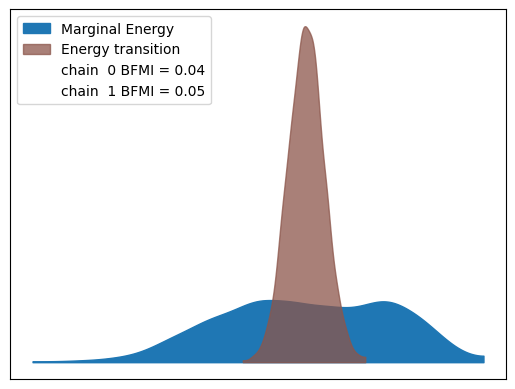

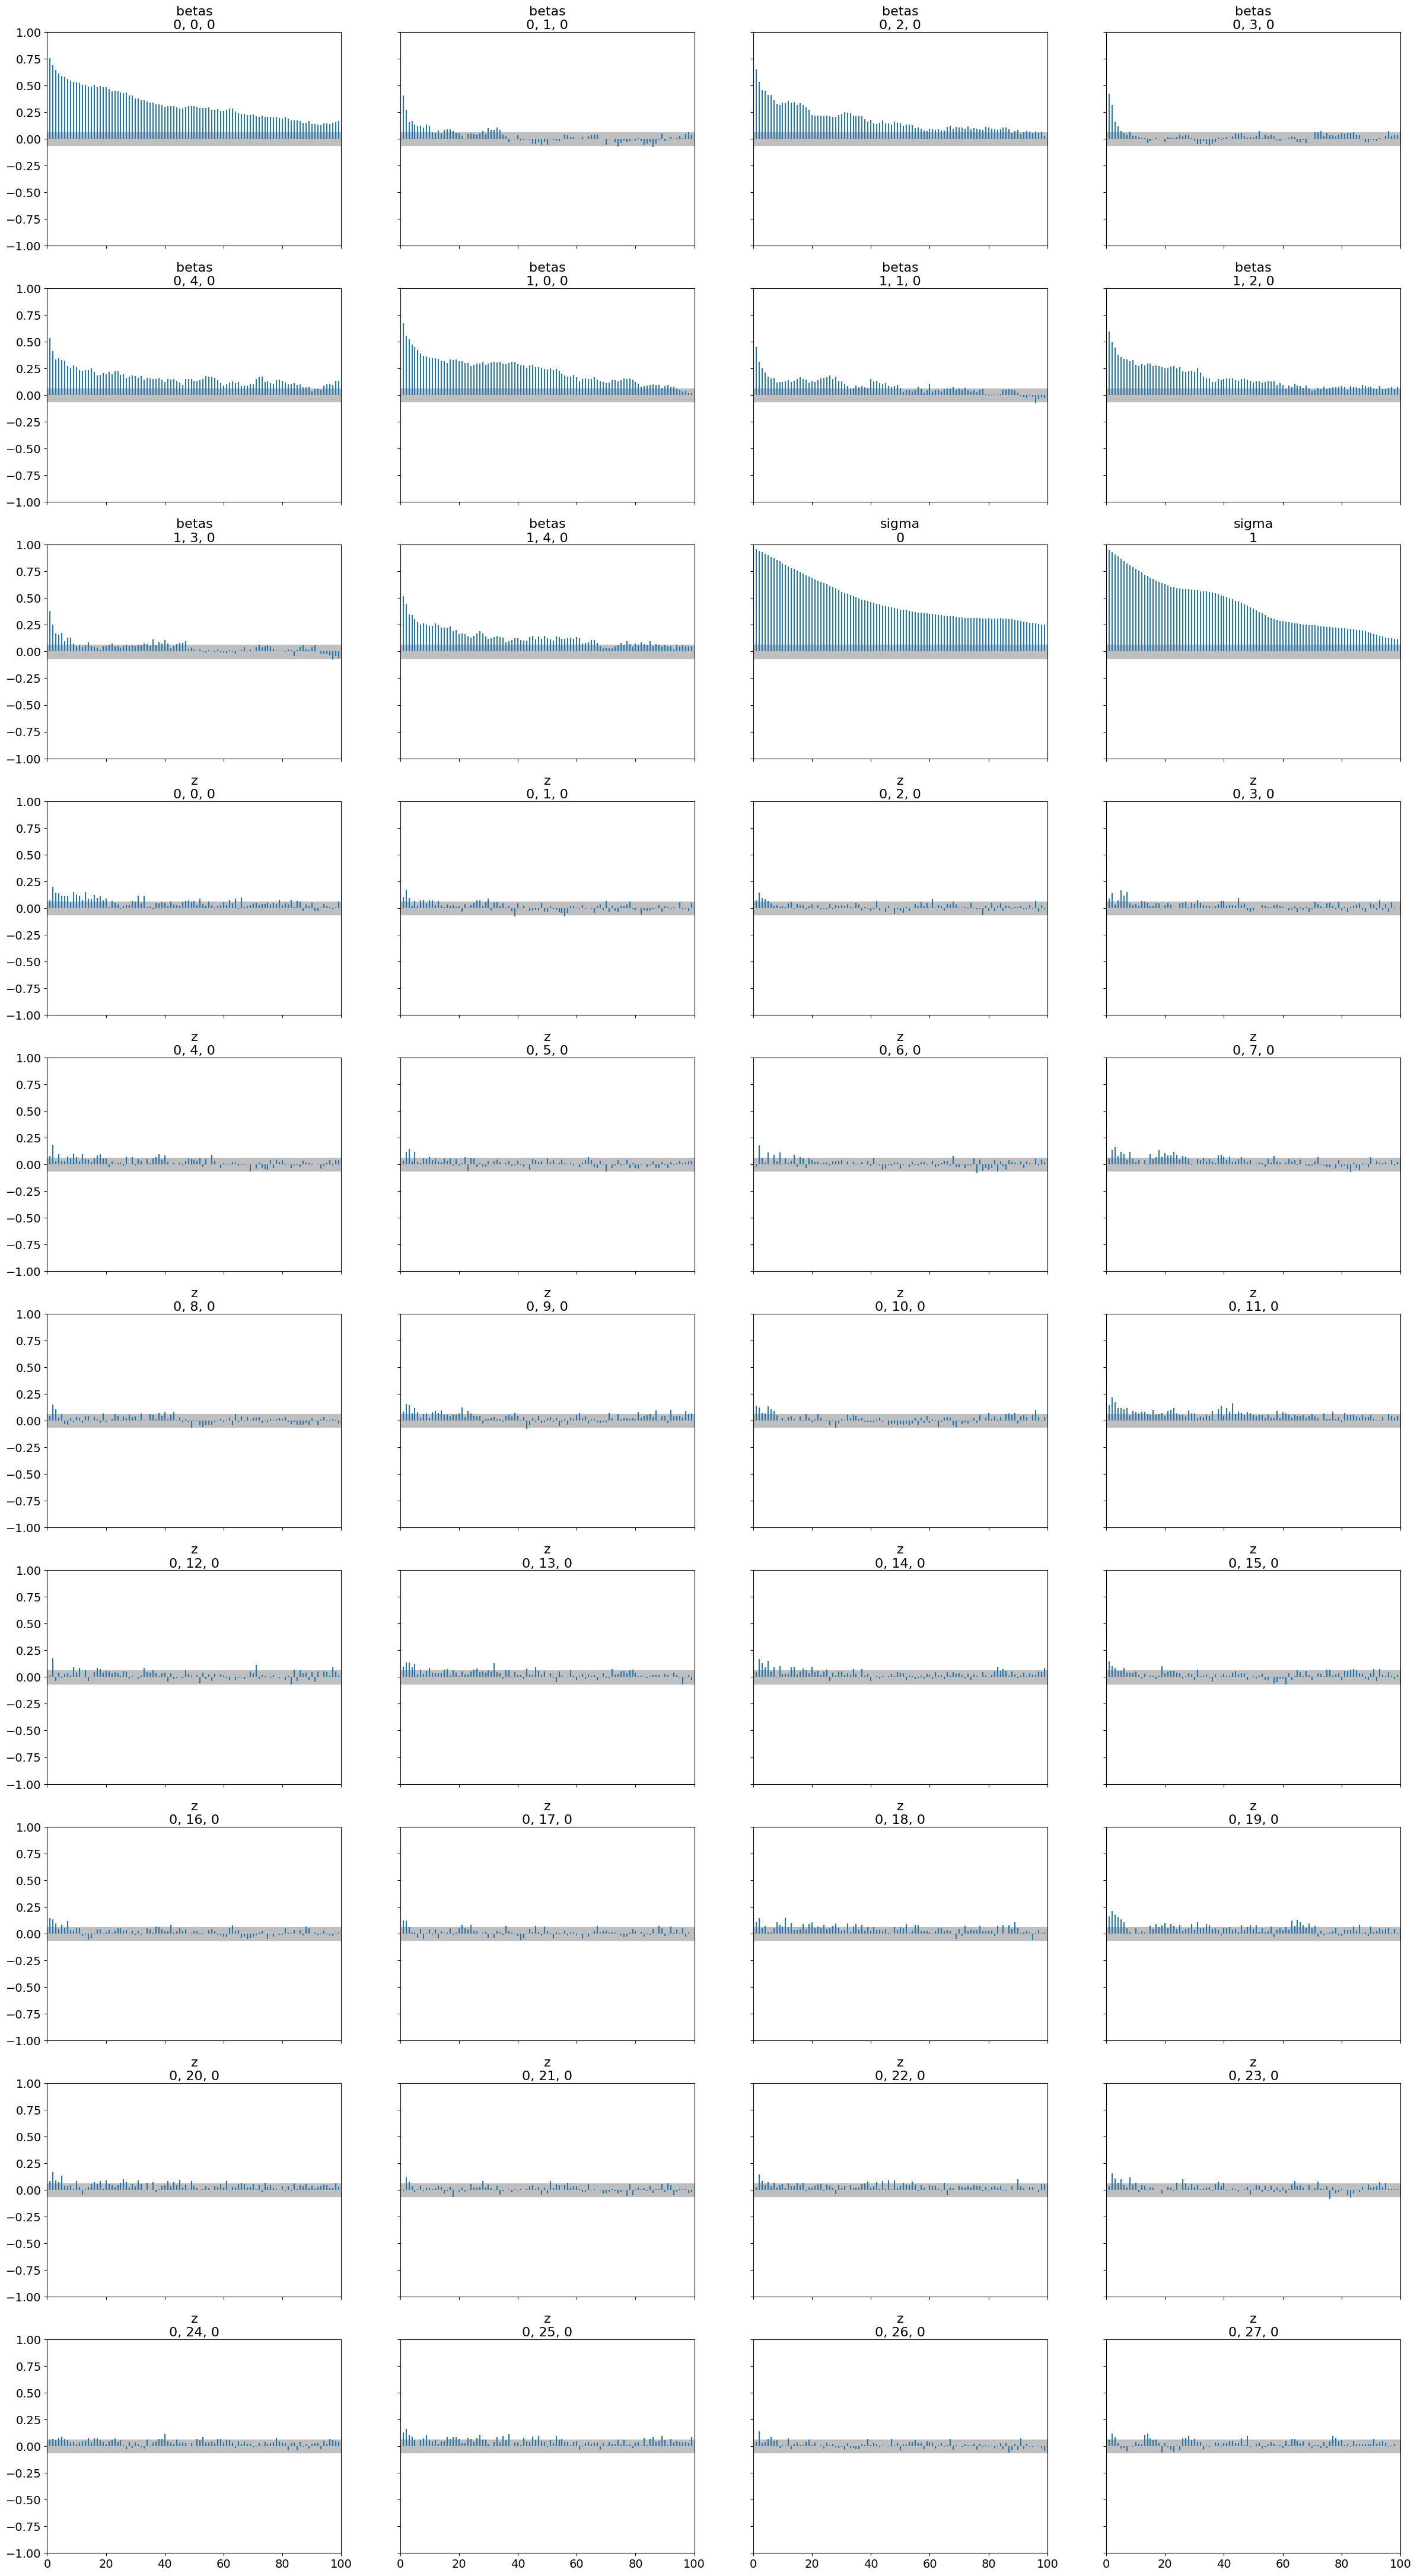

In [9]:
#Q3
#https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Load dataset
file_path = "diabetes.csv"
df = pd.read_csv(file_path)

# Select features and target
X_vars = ['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']
Y_var = 'Outcome'

# Standardize numerical features
scaler = StandardScaler()
df[X_vars] = scaler.fit_transform(df[X_vars])

# Define features and target
X = df[X_vars].values
Y = df[Y_var].values[:, np.newaxis]  # Ensure Y is a column vector

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define Bayesian Probit Regression Model
n, p = X_train.shape  # n: samples, p: predictors

with pm.Model() as probit_model:

    # Prior for regression coefficients
    betas = pm.Normal('betas', mu=0, sigma=1, shape=(p, 1))

    # Standard deviation for latent normal variable
    sigma = pm.Exponential('sigma', 1.0)

    # Latent normal variable
    z = pm.Normal('z', mu=pm.math.dot(X_train, betas), sigma=sigma, shape=(n, 1))

    # Probit Likelihood
    y_obs = pm.Bernoulli('y_obs', p=pm.math.invprobit(z), observed=Y_train)

    # MCMC Sampling
    trace = pm.sample(1000, tune=1000, cores=2, target_accept=0.95, return_inferencedata=True)

# Posterior Analysis & MCMC Diagnostics
az.plot_trace(trace, var_names=['betas', 'sigma'])
az.plot_posterior(trace, var_names=['betas', 'sigma'])
az.plot_energy(trace)
az.plot_autocorr(trace)

# Show results
plt.show()


The results indicate that the posterior distribution of `betas` exhibits multiple peaks, suggesting that some regression coefficients have strong influences while others are weaker. The trace plot on the right shows the variation of `betas` across MCMC samples, generally indicating convergence but potentially with some autocorrelation issues.

The second image presents the posterior distributions of `betas` and `sigma` along with their 94% HDI (Highest Density Interval), providing robust estimates of the model parameters.

In the third image, the energy plot shows the performance of the sampler, where the overlap between marginal energy (blue) and energy transition (brown) is moderate. However, the `BFMI` values (0.04 and 0.05) are quite low, suggesting inefficient sampling. This may require adjustments such as increasing `target_accept` or adding more tuning steps.

Finally, the bar plots illustrate the marginal distributions of some coefficients, with certain variables exhibiting narrower distributions, implying a smaller contribution to the model. Overall, the model runs successfully but may require further optimization to improve sampling efficiency and convergence.